# Analysis of the Cognitive Control Design Space with MOFA+

This notebook trains and analyzes a Multi-Omics Factor Analysis (MOFA+) model on the cognitive control literature dataset. The goal is to extend the initial PCA by using a more flexible, probabilistic framework capable of handling heterogeneous data types and inferring robust latent factors.

The workflow is as follows:
1.  **Load and Preprocess Data**: Use the `mofa_utils.py` script to transform the wide-format CSV into the long format required by `mofapy2`.
2.  **Train the MOFA+ Model**: Configure and run the `mofapy2` training pipeline. This step is computationally intensive and the model will be saved to disk to avoid re-running.
3.  **Analyze the Trained Model**: Use the `mofax` library to load the saved model and analyze its components:
    *   **Variance Explained**: Determine the importance of each factor.
    *   **Latent Space Visualization**: Plot the factors to visualize the structure of the experimental space, analogous to a PCA plot.
    *   **Factor Interpretation**: Examine the feature weights to understand the conceptual meaning of each latent factor.
4.  **Advanced Analysis**: Discuss the path towards advanced analyses like interpolation, highlighting the differences from the PCA workflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plot
import pickle
from IPython.display import display
from pathlib import Path
import pickle
import analysis_utils as au
import plot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import altair as alt

# MOFA+ libraries
from mofapy2.run.entry_point import entry_point
import mofax as mfx

# Setup plotting style and display options
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully.")
ard_factors = True
print(f"Configuring model to use ard_factors={ard_factors}.")
# Define the model folder and file path
model_folder_path = Path("mofa_models")

Libraries loaded successfully.
Configuring model to use ard_factors=True.


In [3]:
# Load the raw dataset
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv', keep_default_na=False)
    df_raw = pd.DataFrame(df_raw).replace('N/A', np.nan)
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")

STRATEGY = "dense"
MERGE_CONFLICT_DIMENSIONS = True
# Preprocess the data into the long format required by mofapy2
df_features, _, _, df_processed, _ = au.preprocess(df_raw, merge_conflict_dimensions=MERGE_CONFLICT_DIMENSIONS, target='mofa')
df_long, likelihoods, preprocessor, view_map = au.prepare_mofa_data(df_raw, strategy=STRATEGY, merge_conflict_dimensions=MERGE_CONFLICT_DIMENSIONS)
print("\nPreprocessing for MOFA+ complete.")
os.makedirs(model_folder_path, exist_ok=True)
pickle.dump(preprocessor, open(model_folder_path / "preprocessor.pkl", 'wb'))

# Note: We no longer need to save a preprocessor for MOFA+ since it doesn't use sklearn transformers
# The preprocessor was only needed for the PCA pipeline's inverse transform capability
# MOFA+ handles its own internal transformations and doesn't require inverse transforms
sample_experiment = 'Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials'
print(f"Cleaned data for {sample_experiment}:")
cleaned_experiment_data = df_processed[df_processed['Experiment'] == sample_experiment]
display(cleaned_experiment_data)
# Check if the sample experiment still exists in the long format
sample_data = df_long[df_long['sample'] == sample_experiment]
if len(sample_data) > 0:
  print(f"Long form data for {sample_experiment}:")
  display(sample_data)
else:
  print(f"Sample experiment '{sample_experiment}' not found.")
  print("Available sample names:")
  print(df_long['sample'].unique()[:10])  # Show first 10 sample names

Successfully loaded raw dataset. Shape: (393, 26)

Preprocessing for MOFA+ complete.
Cleaned data for Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials:


,Experiment,Number of Tasks,Task 2 Response Probability,Inter-task SOA is Predictable,Inter-task SOA,Distractor SOA,Task 1 CSI,Task 2 CSI,Switch Rate,Trial Transition Type,Stimulus-Stimulus Congruency,Stimulus-Response Congruency,Response Set Overlap,Task 1 Stimulus-Response Mapping,Task 2 Stimulus-Response Mapping,Task 1 Cue Type,Task 2 Cue Type,RSI is Predictable,RSI,Task 1 Difficulty,Task 2 Difficulty,Task 1 Type,Task 2 Type,Intra-Trial Task Relationship,Notes,Super_Experiment_Mapping_Notes,Task 1 Difficulty Norm,Task 2 Difficulty Norm,Paradigm,Inter-task SOA is NA,Distractor SOA is NA,Task 2 CSI is NA,Task 2 Difficulty is NA,Stimulus Bivalence & Congruency,SBC_Mapped,Response Set Overlap Mapped,Task 1 Stimulus-Response Mapping Mapped,Task 1 Cue Type Mapped,Task 2 Stimulus-Response Mapping Mapped,Task 2 Cue Type Mapped,Trial Transition Type Mapped,Intra-Trial Task Relationship Mapped
118,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,1,0,NaN,150.0,0.0,100,0.0,0.0,Pure,NaN,NaN,NaN,Arbitrary,NaN,Arbitrary,NaN,1,1600.0,3.0,NaN,Shape/Color Discrimination,NaN,NaN,,,0.5,0.369963,Single-Task,1,1,1,1,N/A,N/A,RSO_NA,SRM_Arbitrary,TCT_Arbitrary,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA


Long form data for Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials:


,sample,feature,value,view,group
118,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 Response Probability,-5.646166e-01,Structure,all_studies
511,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Inter-task SOA,-1.577921e-01,Temporal,all_studies
904,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Distractor SOA,-1.641230e-01,Temporal,all_studies
1297,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 1 CSI,-9.877367e-02,Temporal,all_studies
1690,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 CSI,-2.598522e-01,Temporal,all_studies
2083,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__RSI,1.546171e-01,Temporal,all_studies
2476,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Switch Rate,-8.696237e-01,Context,all_studies
2869,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 1 Difficulty,1.253612e+00,Task_Properties,all_studies
3262,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 Difficulty,4.398802e-16,Task_Properties,all_studies
3655,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,cat__Inter-task SOA is NA_0,0.000000e+00,Temporal,all_studies


In [4]:
# --- Configuration ---
def train_model(ard_factors=False):
    MODEL_OUTFILE = model_folder_path / f"cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5"
    N_FACTORS = 15 # The initial number of factors to learn
    
    # To save time, we check if the model has already been trained.
    if not os.path.exists(MODEL_OUTFILE):
        print("Model file not found. Training a new MOFA+ model...")
        
        # 1. Initialize the entry point
        ent = entry_point()
    
        # 2. Set the data from the preprocessed long DataFrame
        # The likelihoods correspond to the views in alphabetical order
        ent.set_data_df(df_long, likelihoods=likelihoods)
    
        # 3. Set model options
        # - factors: Initial number of latent dimensions to learn.
        # - spikeslab_weights: Enforces sparsity, pushing non-informative weights to zero. Crucial for interpretability.
        ent.set_model_options(
            factors=N_FACTORS,
            spikeslab_weights=True, 
            ard_weights=True,
            ard_factors=ard_factors
        )
    
        # 4. Set training options
        # - iter: Maximum number of iterations.
        # - convergence_mode: 'fast' is good for exploration.
        # - dropR2: Automatically drops factors explaining less than this variance threshold during training.
        # - seed: For reproducibility.
        ent.set_train_options(
            iter=1000,
            convergence_mode="slow",
            dropR2=0.001, 
            seed=2024
        )
        
        # 5. Build, run, and save the model
        print("Building model...")
        ent.build()
        
        print("\nRunning model training (this may take several minutes)...")
        ent.run()
        
        print(f"\nSaving trained model to {MODEL_OUTFILE}...")
        # Ensure the directory exists
        os.makedirs(os.path.dirname(MODEL_OUTFILE), exist_ok=True)
        ent.save(MODEL_OUTFILE)
        
        print("Model training complete.")
    else:
        print(f"Found existing model file at {MODEL_OUTFILE}. Skipping training.")

In [5]:
train_model(ard_factors)

Model file not found. Training a new MOFA+ model...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='all_studies' view='Conflict' with N=393 samples and D=4 features...
Loaded group='all_studies' view='Context' with N=393 samples and D=5 features...
Loaded group='all_studies' view='Rules' with N=393 samples and D=10 features...
Loaded group='all_studies' view='Structure' with N=393 samples and D=6 features...
L

In [6]:
MODEL_OUTFILE = model_folder_path / f"cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5"
# Load the trained model using the mofax library for analysis
try:
    model = mfx.mofa_model(MODEL_OUTFILE)
    print("Trained MOFA+ model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

if model:
    # Inspect the basic properties of the model
    print(f"\nNumber of experiments (samples): {model.shape[0]}")
    print(f"Number of parameters (features): {model.shape[1]}")
    print(f"Number of factors inferred: {model.nfactors}")
    print(f"Data views: {model.views}")
    print(f"Sample groups: {model.groups}")

Trained MOFA+ model loaded successfully.

Number of experiments (samples): 393
Number of parameters (features): 45
Number of factors inferred: 4
Data views: [np.str_('Conflict'), np.str_('Context'), np.str_('Rules'), np.str_('Structure'), np.str_('Task_Properties'), np.str_('Temporal')]
Sample groups: [np.str_('all_studies')]


The R² value for each factor shows how much of the variance in the experimental parameters it explains. This is the primary way to assess a factor's importance. We can break this down by *view* (parameter type) or *group* (paradigm class).

--- Variance Explained (R²) per Factor and View ---


,Factor,View,Group,R2
0,Factor1,Conflict,all_studies,0.055755
1,Factor1,Context,all_studies,30.416825
2,Factor1,Rules,all_studies,35.829273
3,Factor1,Structure,all_studies,24.151585
4,Factor1,Task_Properties,all_studies,29.075047


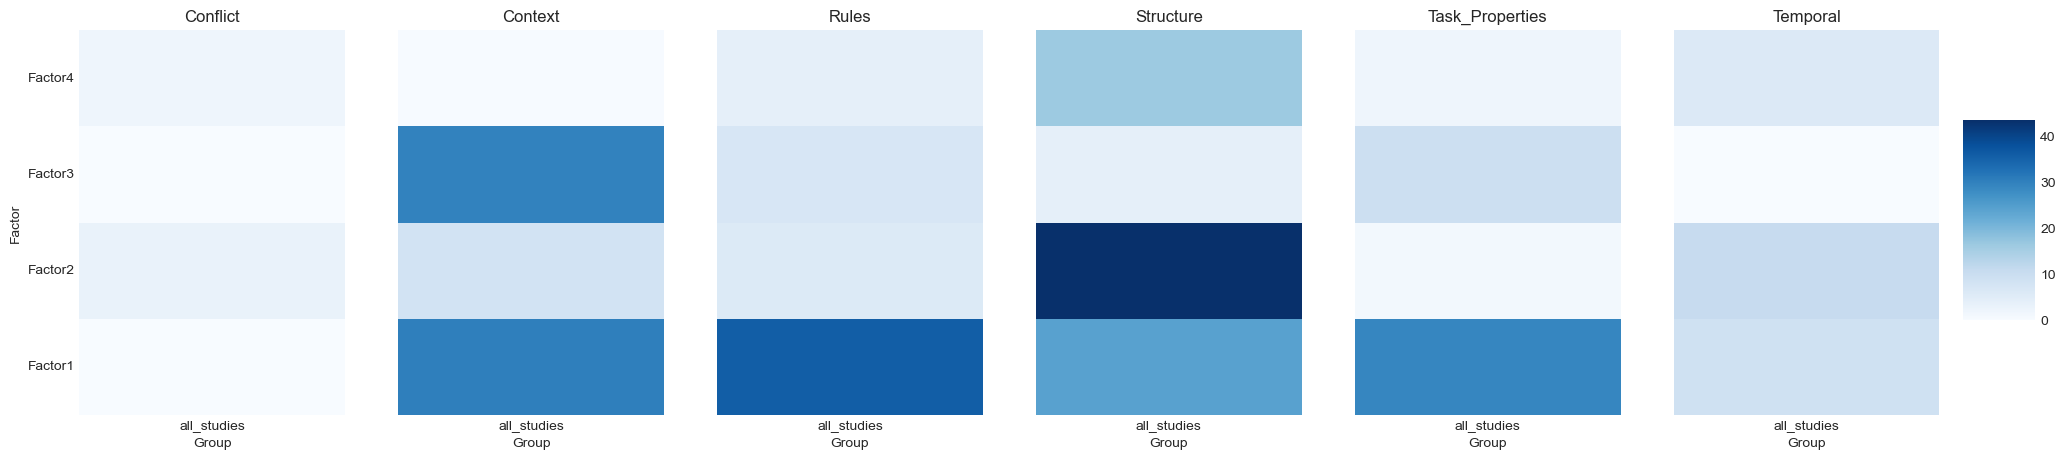

In [7]:
if model:
    # Get the R² values as a DataFrame
    r2_df = model.get_variance_explained()
    print("--- Variance Explained (R²) per Factor and View ---")
    display(r2_df.head())
    
    # Create a heatmap of the R² values
    # This shows which factors are most important for which paradigm classes.
    #fig, ax = plt.subplots(figsize=(8, 6))
    fig = mfx.plot_r2(model, x='Group', y='Factor')
    fig.savefig("r2_mofa_dense.png", bbox_inches='tight')
    fig

To understand what a factor *means*, we must examine its weights. Features (experimental parameters) with high positive or negative weights are the ones that define that factor.

--- Generating custom plot for Factor 1 ---


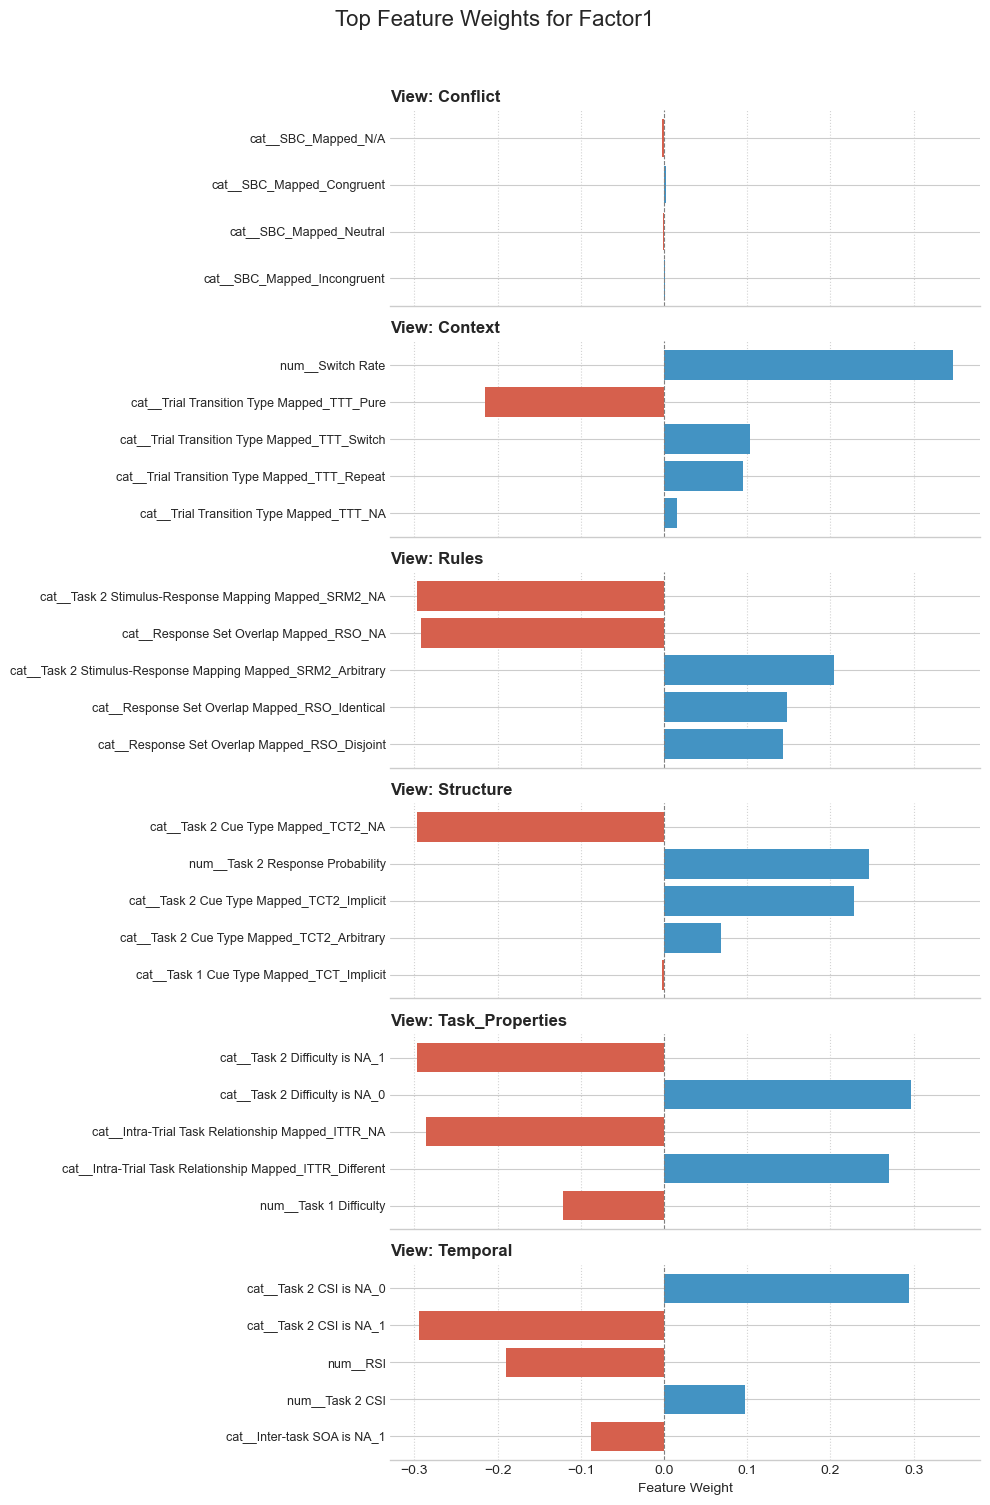

--- Generating custom plot for Factor 2 ---


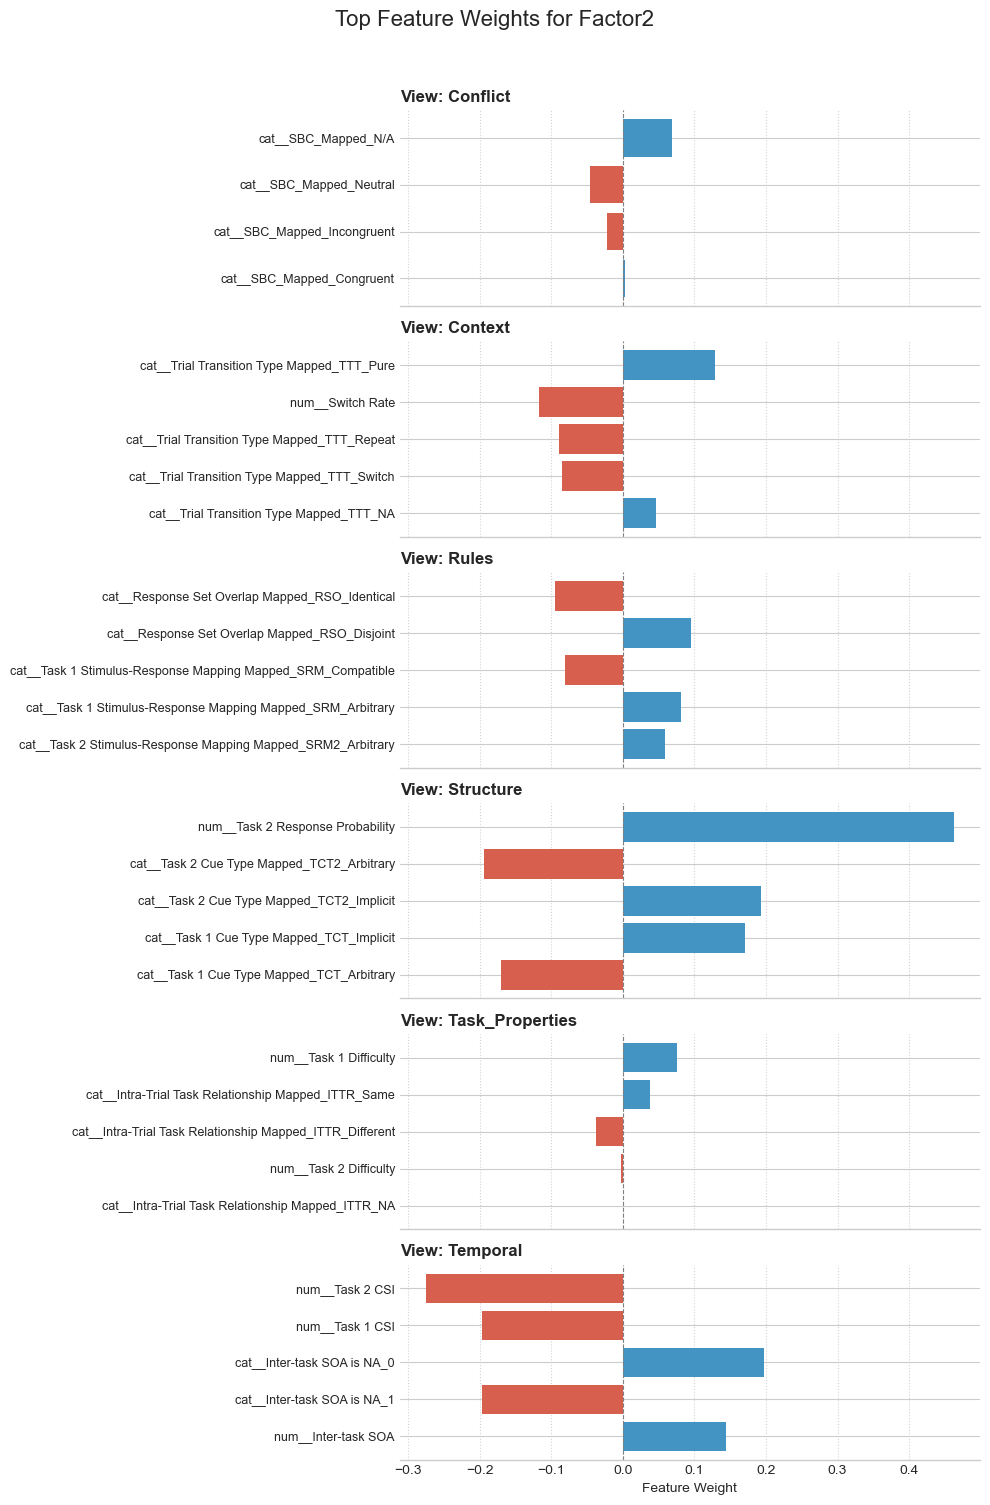

In [8]:
# --- How to use the new function ---
if model:
    print("--- Generating custom plot for Factor 1 ---")
    fig1 = plot.plot_factor_weights_by_view(model, "Factor1", n_features_per_view=5)
    plt.savefig("factor_1_weights_dense.png")
    plt.show()

    print("--- Generating custom plot for Factor 2 ---")
    fig2 = plot.plot_factor_weights_by_view(model, "Factor2", n_features_per_view=5)
    plt.savefig("factor_2_weights_dense.png")
    plt.show()


      
The plot below is the direct analog of the PCA scatter plot. Each point is an experimental condition, plotted in the space defined by the latent factors. We color by the paradigm class (group) assigned during preprocessing to see if the factors successfully separate these classes.

    

In [14]:
# --- 5. Define Tooltip Columns ---
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA:N', title='Inter-task SOA'),
    alt.Tooltip('Distractor SOA:N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('Task 2 CSI:Q', title='T2 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('RSI is Predictable:N', title='RSI Predictable'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    #alt.Tooltip('Stimulus-Stimulus Congruency:N', title='Stimulus-Stimulus Congruency'),
    #alt.Tooltip('Stimulus-Response Congruency:N', title='Stimulus-Response Congruency'),
    alt.Tooltip('Stimulus Bivalence & Congruency:N', title='Stimulus Bivalence & Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Stimulus-Response Mapping:N', title='T1 Stimulus-Response Mapping'),
    alt.Tooltip('Task 2 Stimulus-Response Mapping:N', title='T2 Stimulus-Response Mapping'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 CSI is NA:N', title='T2 CSI is N/A'),
    alt.Tooltip('Task 2 Difficulty is NA:N', title='T2 Difficulty is N/A'),
    alt.Tooltip('Inter-task SOA is NA:N', title='Inter-task SOA is N/A'),
    alt.Tooltip('Distractor SOA is NA:N', title='Distractor SOA is N/A'),
    alt.Tooltip('Intra-Trial Task Relationship:N', title='Intra-Trial Task Relationship')
]
model_filepath = f"mofa_models/cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5" 
mofa_model = mfx.mofa_model(model_filepath)
factors_df = mofa_model.get_factors(df=True)

# --- 1. Combine data and calculate centroids ---
mofa_plot_df = pd.concat([
    df_processed.reset_index(drop=True),
    factors_df.reset_index(drop=True)
], axis=1)
mofa_plot_df['Point Type'] = 'Empirical Data'

centroids_df = au.find_centroids(mofa_plot_df[[c for c in mofa_plot_df.columns if c.startswith("Factor")] + ["Paradigm"]], paradigm_col='Paradigm')
centroids_df = pd.DataFrame.from_dict(centroids_df, orient='index').reset_index()
centroids_df = centroids_df.rename(columns={'index': 'Paradigm'})
centroids_df['Point Type'] = 'Centroid'

# --- 2. Generate interpolated points using the new utility function ---
interpolation_pairs = [
    ('Dual-Task_PRP', 'Task Switching'),
    ('Dual-Task_PRP', 'Interference'),
    ('Task Switching', 'Interference')
]

model_artifacts_mofa = {'type': 'mofa', 'model': mofa_model, 'preprocessor': preprocessor}

interpolated_df = au.generate_interpolated_points(
    latent_space_df=mofa_plot_df,
    model_artifacts=model_artifacts_mofa,
    interpolation_pairs=interpolation_pairs
)

final_plot_df = pd.concat([mofa_plot_df, centroids_df, interpolated_df], ignore_index=True)
final_plot_df['Parent1'] = final_plot_df['Parent1'].fillna('N/A')
final_plot_df['Parent2'] = final_plot_df['Parent2'].fillna('N/A')
final_plot_df = plot.add_na_mask_from_flag(final_plot_df)

# Now, call the plotting function from plot.py
mofa_chart = plot.create_latent_space_plot(final_plot_df, "Factor1", "Factor2", "Factor 1", "Factor 2", "Conditions on MOFA+'s First Two Factors, Dense Dataset", tooltip_cols,
                                          has_interpolation=True, output_filename="mofa_plot_dense_dataset.json")
mofa_chart

alt.LayerChart(...)

In [10]:
print("\n--- VARIANCE EXPLAINED BY MODEL ---")
mofa_r2_table = mofa_model.get_variance_explained()
total_r2_per_view = mofa_r2_table.groupby('View')['R2'].sum()
print(total_r2_per_view)
weights = {view: len(features) for view, features in au.get_view_mapping_unified(False).items()}
weights_series = pd.Series(weights)
print(weights_series)
weighted_r2_sum = (total_r2_per_view * weights_series).sum()
total_weight = weights_series.sum()
weighted_average_r2 = weighted_r2_sum / total_weight

print(f"Total weighted R^2: {weighted_average_r2:.2f}%")
display(mofa_model.get_weights().shape)
transposed_loadings = mofa_model.get_weights().T  # Shape will be (4, 45)

# 2. Apply the function to each row (i.e., each factor)
factor_sparsities = np.mean([au.sparseness_hoyer(factor) for factor in transposed_loadings])

print(f"Sparsity for each of the 3 factors: {factor_sparsities}")


--- VARIANCE EXPLAINED BY MODEL ---
View
Conflict            5.291592
Context            68.823717
Rules              52.751176
Structure          87.985374
Task_Properties    41.926052
Temporal           25.867754
Name: R2, dtype: float64
Temporal           5
Context            3
Task_Properties    3
Conflict           3
Rules              3
Structure          3
dtype: int64
Total weighted R^2: 44.98%


(45, 4)

Sparsity for each of the 3 factors: 0.42741896060192797
